In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3,4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_BN_2(conv_num=1):
    kernel_size = 64
    filter_size = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3*kernel_size, filters=filter_size, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        target_kernel_size = 3 * (kernel_size//(2**(i+1)))
        model.add(Conv1D (kernel_size=target_kernel_size if target_kernel_size != 0 else 3, 
                          filters=filter_size*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        24704     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        1572992   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 128)        0         
_________________________________________________________________
max_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 128)        24704     
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 128)        1572992   
_________________________________________________________________
batch_normalization_v1_16 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 128)        24704     
_________________________________________________________________
batch_normalization_v1_39 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 128)        1572992   
_________________________________________________________________
batch_normalization_v1_40 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6783 - acc: 0.3804
Epoch 00001: val_loss improved from inf to 3.64608, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_3_conv_checkpoint/001-3.6461.hdf5
36805/36805 [==============================] - 400s 11ms/sample - loss: 3.6780 - acc: 0.3804 - val_loss: 3.6461 - val_acc: 0.4675
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0817 - acc: 0.5627
Epoch 00002: val_loss did not improve from 3.64608
36805/36805 [==============================] - 401s 11ms/sample - loss: 3.0824 - acc: 0.5626 - val_loss: 3.8265 - val_acc: 0.5295
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6562 - acc: 0.6420
Epoch 00003: val_loss did not improve from 3.64608
36805/36805 [==============================] - 404s 11ms/sample - loss: 2.6564 - acc: 0.6420 - val_

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5191 - acc: 0.9442
Epoch 00028: val_loss did not improve from 3.00705
36805/36805 [==============================] - 398s 11ms/sample - loss: 0.5192 - acc: 0.9441 - val_loss: 4.4531 - val_acc: 0.6415
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5227 - acc: 0.9445
Epoch 00029: val_loss did not improve from 3.00705
36805/36805 [==============================] - 400s 11ms/sample - loss: 0.5233 - acc: 0.9444 - val_loss: 3.4850 - val_acc: 0.7042
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4990 - acc: 0.9482
Epoch 00030: val_loss did not improve from 3.00705
36805/36805 [==============================] - 397s 11ms/sample - loss: 0.5002 - acc: 0.9481 - val_loss: 3.5322 - val_acc: 0.7051
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4612 - acc: 0.9530
Epoch 00031: val_loss did not improve from 3.00705
36805/36805 [=====

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3140 - acc: 0.9715
Epoch 00058: val_loss did not improve from 3.00705
36805/36805 [==============================] - 404s 11ms/sample - loss: 0.3141 - acc: 0.9715 - val_loss: 3.9468 - val_acc: 0.6930
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3550 - acc: 0.9668
Epoch 00059: val_loss did not improve from 3.00705
36805/36805 [==============================] - 403s 11ms/sample - loss: 0.3550 - acc: 0.9668 - val_loss: 3.6092 - val_acc: 0.7147
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3190 - acc: 0.9707
Epoch 00060: val_loss did not improve from 3.00705
36805/36805 [==============================] - 402s 11ms/sample - loss: 0.3198 - acc: 0.9707 - val_loss: 3.4571 - val_acc: 0.7286

1D_CNN_custom_kernel_192_ch_128_BN_3_conv Model


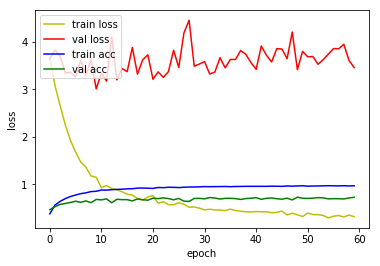

4815/4815 [==============================] - 16s 3ms/sample - loss: 3.2763 - acc: 0.6559
Loss: 3.27631092121049 Accuracy: 0.6558671

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2168 - acc: 0.4305
Epoch 00001: val_loss improved from inf to 2.18796, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_4_conv_checkpoint/001-2.1880.hdf5
36805/36805 [==============================] - 433s 12ms/sample - loss: 2.2171 - acc: 0.4304 - val_loss: 2.1880 - val_acc: 0.4729
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6210 - acc: 0.6039
Epoch 00002: val_loss improved from 2.18796 to 1.94045, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_4_conv_checkpoint/002-1.9404.hdf5
36805/36805 [==============================] - 397s 11ms/sample - loss: 1.6215 - acc: 0.6038 - val_loss: 1.9404 - val_acc: 0.5663
Epoch 3/500
36800/36805 [============================>

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1741 - acc: 0.9603
Epoch 00028: val_loss did not improve from 1.10932
36805/36805 [==============================] - 401s 11ms/sample - loss: 0.1742 - acc: 0.9602 - val_loss: 1.5512 - val_acc: 0.7887
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1628 - acc: 0.9627
Epoch 00029: val_loss did not improve from 1.10932
36805/36805 [==============================] - 402s 11ms/sample - loss: 0.1635 - acc: 0.9627 - val_loss: 1.4726 - val_acc: 0.7918
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1506 - acc: 0.9654
Epoch 00030: val_loss did not improve from 1.10932
36805/36805 [==============================] - 398s 11ms/sample - loss: 0.1506 - acc: 0.9654 - val_loss: 1.4818 - val_acc: 0.8011
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1387 - acc: 0.9677
Epoch 00031: val_loss did not improve from 1.10932
36805/36805 [=====

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0735 - acc: 0.9843
Epoch 00058: val_loss did not improve from 1.10932
36805/36805 [==============================] - 396s 11ms/sample - loss: 0.0740 - acc: 0.9843 - val_loss: 1.5929 - val_acc: 0.8139

1D_CNN_custom_kernel_192_ch_128_BN_4_conv Model


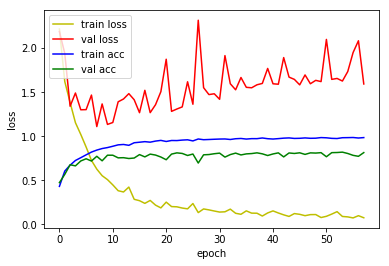

4815/4815 [==============================] - 16s 3ms/sample - loss: 1.1893 - acc: 0.7485
Loss: 1.1892912869760428 Accuracy: 0.74849427

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9502 - acc: 0.4539
Epoch 00001: val_loss improved from inf to 1.59214, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_5_conv_checkpoint/001-1.5921.hdf5
36805/36805 [==============================] - 422s 11ms/sample - loss: 1.9504 - acc: 0.4538 - val_loss: 1.5921 - val_acc: 0.5586
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3163 - acc: 0.6434
Epoch 00002: val_loss improved from 1.59214 to 1.22274, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_5_conv_checkpoint/002-1.2227.hdf5
36805/36805 [==============================] - 418s 11ms/sample - loss: 1.3167 - acc: 0.6433 - val_loss: 1.2227 - val_acc: 0.6928
Epoch 3/500
36800/36805 [==========================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1765 - acc: 0.9522
Epoch 00028: val_loss did not improve from 0.63364
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.1769 - acc: 0.9522 - val_loss: 0.8514 - val_acc: 0.8600
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1413 - acc: 0.9604
Epoch 00029: val_loss did not improve from 0.63364
36805/36805 [==============================] - 421s 11ms/sample - loss: 0.1416 - acc: 0.9604 - val_loss: 0.8053 - val_acc: 0.8761
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1655 - acc: 0.9571
Epoch 00030: val_loss did not improve from 0.63364
36805/36805 [==============================] - 423s 11ms/sample - loss: 0.1657 - acc: 0.9570 - val_loss: 1.0265 - val_acc: 0.8486
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1569 - acc: 0.9593
Epoch 00031: val_loss did not improve from 0.63364
36805/36805 [=====

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0959 - acc: 0.9769
Epoch 00058: val_loss did not improve from 0.63364
36805/36805 [==============================] - 421s 11ms/sample - loss: 0.0961 - acc: 0.9769 - val_loss: 0.9062 - val_acc: 0.8842
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0988 - acc: 0.9762
Epoch 00059: val_loss did not improve from 0.63364
36805/36805 [==============================] - 423s 11ms/sample - loss: 0.0988 - acc: 0.9762 - val_loss: 0.9298 - val_acc: 0.8728
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9828
Epoch 00060: val_loss did not improve from 0.63364
36805/36805 [==============================] - 425s 12ms/sample - loss: 0.0708 - acc: 0.9828 - val_loss: 0.8753 - val_acc: 0.8919
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9819
Epoch 00061: val_loss did not improve from 0.63364
36805/36805 [=====

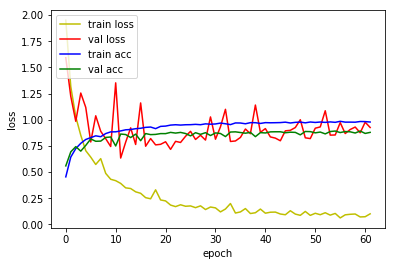

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.7772 - acc: 0.8318
Loss: 0.777234919005589 Accuracy: 0.8317757

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7432 - acc: 0.4691
Epoch 00001: val_loss improved from inf to 1.46137, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_6_conv_checkpoint/001-1.4614.hdf5
36805/36805 [==============================] - 439s 12ms/sample - loss: 1.7432 - acc: 0.4691 - val_loss: 1.4614 - val_acc: 0.5465
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0702 - acc: 0.6782
Epoch 00002: val_loss improved from 1.46137 to 1.22107, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_6_conv_checkpoint/002-1.2211.hdf5
36805/36805 [==============================] - 434s 12ms/sample - loss: 1.0703 - acc: 0.6782 - val_loss: 1.2211 - val_acc: 0.6501
Epoch 3/500
36800/36805 [============================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1284 - acc: 0.9602
Epoch 00025: val_loss did not improve from 0.30213
36805/36805 [==============================] - 433s 12ms/sample - loss: 0.1286 - acc: 0.9602 - val_loss: 0.4556 - val_acc: 0.8970
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9649
Epoch 00026: val_loss did not improve from 0.30213
36805/36805 [==============================] - 433s 12ms/sample - loss: 0.1106 - acc: 0.9649 - val_loss: 0.4300 - val_acc: 0.9012
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9709
Epoch 00027: val_loss did not improve from 0.30213
36805/36805 [==============================] - 436s 12ms/sample - loss: 0.0909 - acc: 0.9708 - val_loss: 0.3553 - val_acc: 0.9152
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9625
Epoch 00028: val_loss did not improve from 0.30213
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9868
Epoch 00055: val_loss did not improve from 0.30213
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0407 - acc: 0.9868 - val_loss: 0.5514 - val_acc: 0.9019
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9867
Epoch 00056: val_loss did not improve from 0.30213
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0412 - acc: 0.9866 - val_loss: 0.3904 - val_acc: 0.9283
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9864
Epoch 00057: val_loss did not improve from 0.30213
36805/36805 [==============================] - 436s 12ms/sample - loss: 0.0435 - acc: 0.9864 - val_loss: 0.3961 - val_acc: 0.9308
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9866
Epoch 00058: val_loss did not improve from 0.30213
36805/36805 [=====

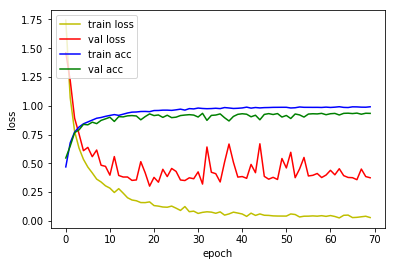

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.3668 - acc: 0.9032
Loss: 0.36683675534752425 Accuracy: 0.9032191

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6970 - acc: 0.4771
Epoch 00001: val_loss improved from inf to 1.14512, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_7_conv_checkpoint/001-1.1451.hdf5
36805/36805 [==============================] - 443s 12ms/sample - loss: 1.6970 - acc: 0.4770 - val_loss: 1.1451 - val_acc: 0.6387
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9769 - acc: 0.7075
Epoch 00002: val_loss did not improve from 1.14512
36805/36805 [==============================] - 442s 12ms/sample - loss: 0.9769 - acc: 0.7075 - val_loss: 1.3804 - val_acc: 0.6070
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6818 - acc: 0.8005
Epoch 00003: val_loss improved from 1.14512 to 0.60055, saving

36800/36805 [============================>.] - ETA: 0s - loss: 0.0855 - acc: 0.9745
Epoch 00026: val_loss did not improve from 0.21139
36805/36805 [==============================] - 435s 12ms/sample - loss: 0.0856 - acc: 0.9745 - val_loss: 0.2586 - val_acc: 0.9350
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9795
Epoch 00027: val_loss did not improve from 0.21139
36805/36805 [==============================] - 437s 12ms/sample - loss: 0.0684 - acc: 0.9794 - val_loss: 0.2153 - val_acc: 0.9422
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9769
Epoch 00028: val_loss did not improve from 0.21139
36805/36805 [==============================] - 441s 12ms/sample - loss: 0.0764 - acc: 0.9769 - val_loss: 0.6179 - val_acc: 0.8453
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9786
Epoch 00029: val_loss did not improve from 0.21139
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9861
Epoch 00055: val_loss did not improve from 0.19329
36805/36805 [==============================] - 439s 12ms/sample - loss: 0.0465 - acc: 0.9861 - val_loss: 0.2462 - val_acc: 0.9460
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9932
Epoch 00056: val_loss did not improve from 0.19329
36805/36805 [==============================] - 440s 12ms/sample - loss: 0.0262 - acc: 0.9932 - val_loss: 0.2583 - val_acc: 0.9427
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9936
Epoch 00057: val_loss did not improve from 0.19329
36805/36805 [==============================] - 438s 12ms/sample - loss: 0.0233 - acc: 0.9936 - val_loss: 0.2141 - val_acc: 0.9527
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9951
Epoch 00058: val_loss did not improve from 0.19329
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9951
Epoch 00084: val_loss did not improve from 0.19126
36805/36805 [==============================] - 429s 12ms/sample - loss: 0.0165 - acc: 0.9951 - val_loss: 0.2266 - val_acc: 0.9539
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9972
Epoch 00085: val_loss did not improve from 0.19126
36805/36805 [==============================] - 431s 12ms/sample - loss: 0.0097 - acc: 0.9972 - val_loss: 0.2413 - val_acc: 0.9557
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9954
Epoch 00086: val_loss did not improve from 0.19126
36805/36805 [==============================] - 429s 12ms/sample - loss: 0.0173 - acc: 0.9953 - val_loss: 0.3273 - val_acc: 0.9331
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9928
Epoch 00087: val_loss did not improve from 0.19126
36805/36805 [==================

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9970
Epoch 00114: val_loss did not improve from 0.19126
36805/36805 [==============================] - 432s 12ms/sample - loss: 0.0101 - acc: 0.9970 - val_loss: 0.2739 - val_acc: 0.9420

1D_CNN_custom_kernel_192_ch_128_BN_7_conv Model


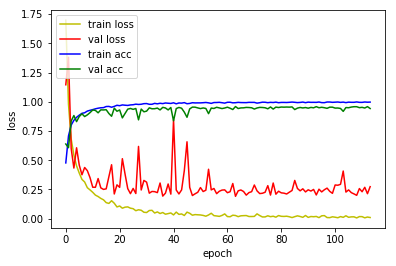

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.2403 - acc: 0.9423
Loss: 0.24029166267049398 Accuracy: 0.9422638

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5573 - acc: 0.5241
Epoch 00001: val_loss improved from inf to 1.02281, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_8_conv_checkpoint/001-1.0228.hdf5
36805/36805 [==============================] - 426s 12ms/sample - loss: 1.5573 - acc: 0.5241 - val_loss: 1.0228 - val_acc: 0.6918
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7626 - acc: 0.7742
Epoch 00002: val_loss improved from 1.02281 to 0.64110, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_8_conv_checkpoint/002-0.6411.hdf5
36805/36805 [==============================] - 456s 12ms/sample - loss: 0.7628 - acc: 0.7741 - val_loss: 0.6411 - val_acc: 0.8085
Epoch 3/500
36800/36805 [==========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9843
Epoch 00027: val_loss improved from 0.15693 to 0.14291, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_8_conv_checkpoint/027-0.1429.hdf5
36805/36805 [==============================] - 398s 11ms/sample - loss: 0.0531 - acc: 0.9843 - val_loss: 0.1429 - val_acc: 0.9599
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9866
Epoch 00028: val_loss did not improve from 0.14291
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0494 - acc: 0.9866 - val_loss: 0.1604 - val_acc: 0.9532
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9917
Epoch 00029: val_loss did not improve from 0.14291
36805/36805 [==============================] - 467s 13ms/sample - loss: 0.0333 - acc: 0.9917 - val_loss: 0.1584 - val_acc: 0.9639
Epoch 30/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9979
Epoch 00055: val_loss did not improve from 0.13345
36805/36805 [==============================] - 399s 11ms/sample - loss: 0.0112 - acc: 0.9978 - val_loss: 0.1553 - val_acc: 0.9623
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9905
Epoch 00056: val_loss did not improve from 0.13345
36805/36805 [==============================] - 419s 11ms/sample - loss: 0.0302 - acc: 0.9905 - val_loss: 0.1403 - val_acc: 0.9641
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9942
Epoch 00057: val_loss did not improve from 0.13345
36805/36805 [==============================] - 472s 13ms/sample - loss: 0.0219 - acc: 0.9941 - val_loss: 0.1561 - val_acc: 0.9576
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9946
Epoch 00058: val_loss did not improve from 0.13345
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9973
Epoch 00084: val_loss did not improve from 0.13242
36805/36805 [==============================] - 418s 11ms/sample - loss: 0.0097 - acc: 0.9973 - val_loss: 0.1351 - val_acc: 0.9660
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9993
Epoch 00085: val_loss did not improve from 0.13242
36805/36805 [==============================] - 473s 13ms/sample - loss: 0.0048 - acc: 0.9993 - val_loss: 0.1540 - val_acc: 0.9637
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0153 - acc: 0.9960
Epoch 00086: val_loss did not improve from 0.13242
36805/36805 [==============================] - 460s 12ms/sample - loss: 0.0153 - acc: 0.9960 - val_loss: 0.1446 - val_acc: 0.9655
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9977
Epoch 00087: val_loss did not improve from 0.13242
36805/36805 [==================

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9983
Epoch 00114: val_loss did not improve from 0.13242
36805/36805 [==============================] - 458s 12ms/sample - loss: 0.0067 - acc: 0.9983 - val_loss: 0.1727 - val_acc: 0.9613
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9988
Epoch 00115: val_loss did not improve from 0.13242
36805/36805 [==============================] - 399s 11ms/sample - loss: 0.0053 - acc: 0.9988 - val_loss: 0.1480 - val_acc: 0.9693
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9959
Epoch 00116: val_loss did not improve from 0.13242
36805/36805 [==============================] - 417s 11ms/sample - loss: 0.0128 - acc: 0.9959 - val_loss: 0.1391 - val_acc: 0.9676
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9980
Epoch 00117: val_loss did not improve from 0.13242
36805/36805 [=

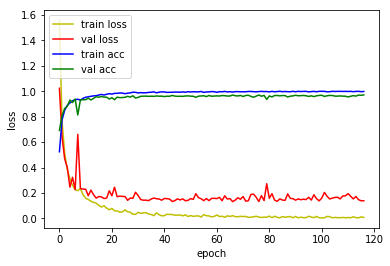

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.1577 - acc: 0.9591
Loss: 0.1576888683119543 Accuracy: 0.9590862

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1557 - acc: 0.6395
Epoch 00001: val_loss improved from inf to 0.85179, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_9_conv_checkpoint/001-0.8518.hdf5
36805/36805 [==============================] - 446s 12ms/sample - loss: 1.1557 - acc: 0.6395 - val_loss: 0.8518 - val_acc: 0.7142
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4613 - acc: 0.8574
Epoch 00002: val_loss improved from 0.85179 to 0.34135, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_BN_9_conv_checkpoint/002-0.3413.hdf5
36805/36805 [==============================] - 435s 12ms/sample - loss: 0.4613 - acc: 0.8574 - val_loss: 0.3413 - val_acc: 0.8959
Epoch 3/500
36800/36805 [===========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9885
Epoch 00027: val_loss did not improve from 0.12034
36805/36805 [==============================] - 435s 12ms/sample - loss: 0.0383 - acc: 0.9885 - val_loss: 0.1662 - val_acc: 0.9548
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9941
Epoch 00028: val_loss did not improve from 0.12034
36805/36805 [==============================] - 435s 12ms/sample - loss: 0.0212 - acc: 0.9940 - val_loss: 0.1380 - val_acc: 0.9611
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9904
Epoch 00029: val_loss did not improve from 0.12034
36805/36805 [==============================] - 436s 12ms/sample - loss: 0.0335 - acc: 0.9903 - val_loss: 0.1363 - val_acc: 0.9616
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9912
Epoch 00030: val_loss did not improve from 0.12034
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9990
Epoch 00056: val_loss did not improve from 0.10938
36805/36805 [==============================] - 439s 12ms/sample - loss: 0.0048 - acc: 0.9990 - val_loss: 0.1141 - val_acc: 0.9711
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9985
Epoch 00057: val_loss did not improve from 0.10938
36805/36805 [==============================] - 436s 12ms/sample - loss: 0.0065 - acc: 0.9985 - val_loss: 0.1497 - val_acc: 0.9630
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9971
Epoch 00058: val_loss did not improve from 0.10938
36805/36805 [==============================] - 437s 12ms/sample - loss: 0.0103 - acc: 0.9971 - val_loss: 0.1775 - val_acc: 0.9562
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9946
Epoch 00059: val_loss did not improve from 0.10938
36805/36805 [==================

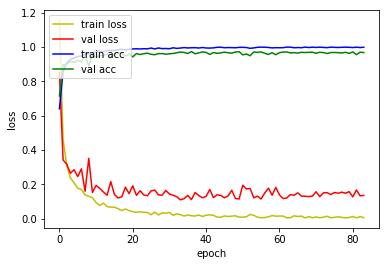

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.1269 - acc: 0.9643
Loss: 0.12693599268198322 Accuracy: 0.9642783



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_kernel_192_ch_128_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_BN_2(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
    
    #         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_ch_128_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           6934928     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 16s 3ms/sample - loss: 0.2403 - acc: 0.9423
Loss: 0.24029166267049398 Accuracy: 0.9422638

1D_CNN_custom_kernel_192_ch_128_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequentia

In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_kernel_192_ch_128_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           6934928     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.3008 - acc: 0.9325
Loss: 0.30081618240070246 Accuracy: 0.93250257

1D_CNN_custom_kernel_192_ch_128_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequenti